### This example demonstrates the XCSF supervised learning mechanisms to perform regression on the Boston house price dataset. Classifiers are composed of tree GP conditions and neural network predictions. A single dummy action is performed such that [A] = [M].

In [1]:
from __future__ import annotations

from typing import Final

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, minmax_scale
from tqdm import tqdm

import xcsf

np.set_printoptions(suppress=True)

### Load training and test data

In [2]:
# Load data from https://www.openml.org/d/189
data = fetch_openml(data_id=189)

# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.data, data.target, test_size=0.1
)

# numpy
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

# reshape into 2D arrays
if len(np.shape(y_train)) == 1:
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

# normalise inputs (zero mean and unit variance)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# scale outputs [0,1]
y_train = minmax_scale(y_train, feature_range=(0, 1))
y_test = minmax_scale(y_test, feature_range=(0, 1))

# get number of input and output variables
X_DIM: Final[int] = np.shape(X_train)[1]
Y_DIM: Final[int] = np.shape(y_train)[1]

# 10% of training for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

print(f"X_train shape = {np.shape(X_train)}")
print(f"y_train shape = {np.shape(y_train)}")
print(f"X_val shape = {np.shape(X_val)}")
print(f"y_val shape = {np.shape(y_val)}")
print(f"X_test shape = {np.shape(X_test)}")
print(f"y_test shape = {np.shape(y_test)}")

X_train shape = (6634, 8)
y_train shape = (6634, 1)
X_val shape = (738, 8)
y_val shape = (738, 1)
X_test shape = (820, 8)
y_test shape = (820, 1)


### Initialise XCSF

In [3]:
xcs: xcsf.XCS = xcsf.XCS(X_DIM, Y_DIM, 1)  # initialise for supervised learning

xcs.OMP_NUM_THREADS = 8  # number of CPU cores to use
xcs.POP_SIZE = 500  # maximum population size
xcs.MAX_TRIALS = 1000  # number of trials per fit()
xcs.LOSS_FUNC = "mse"  # mean squared error
xcs.E0 = 0.005  # target error
xcs.ALPHA = 1  # accuracy offset
xcs.NU = 20  # accuracy slope
xcs.THETA_EA = 50  # EA invocation frequency
xcs.THETA_DEL = 50  # min experience before fitness used in deletion
xcs.BETA = 0.1  # update rate for error, etc.
xcs.action("integer")  # (dummy) integer actions

TREE_ARGS: Final[dict] = {
    "min_constant": 0,  # minimum value of a constant
    "max_constant": 1,  # maximum value of a constant
    "n_constants": 100,  # number of (global) constants
    "init_depth": 5,  # initial tree depth
    "max_len": 10000,  # maximum initial length
}
xcs.condition("tree_gp", TREE_ARGS)  # GP tree conditions

PREDICTION_LAYERS: Final[dict] = {
    "layer_0": {  # hidden layer
        "type": "connected",
        "activation": "relu",
        "sgd_weights": True,
        "evolve_weights": True,
        "evolve_connect": True,
        "evolve_eta": True,
        "eta": 0.1,
        "eta_min": 0.000001,
        "momentum": 0.9,
        "n_init": 10,
        "n_max": 10,
    },
    "layer_1": {  # output layer
        "type": "connected",
        "activation": "softplus",
        "sgd_weights": True,
        "evolve_weights": True,
        "evolve_connect": True,
        "evolve_eta": True,
        "eta": 0.1,
        "eta_min": 0.000001,
        "momentum": 0.9,
        "n_init": Y_DIM,
    },
}
xcs.prediction("neural", PREDICTION_LAYERS)  # neural network predictions

print(xcs.json_parameters())

{
	"version":	"1.1.6",
	"x_dim":	8,
	"y_dim":	1,
	"n_actions":	1,
	"omp_num_threads":	8,
	"pop_init":	true,
	"max_trials":	1000,
	"perf_trials":	1000,
	"pop_size":	500,
	"loss_func":	"mse",
	"set_subsumption":	false,
	"theta_sub":	100,
	"e0":	0.005,
	"alpha":	1,
	"nu":	20,
	"beta":	0.1,
	"delta":	0.1,
	"theta_del":	50,
	"init_fitness":	0.01,
	"init_error":	0,
	"m_probation":	10000,
	"stateful":	true,
	"compaction":	false,
	"ea":	{
		"select_type":	"roulette",
		"theta_ea":	50,
		"lambda":	2,
		"p_crossover":	0.8,
		"err_reduc":	1,
		"fit_reduc":	0.1,
		"subsumption":	false,
		"pred_reset":	false
	},
	"condition":	{
		"type":	"tree_gp",
		"args":	{
			"min_constant":	0,
			"max_constant":	1,
			"n_constants":	100,
			"init_depth":	5,
			"max_len":	10000
		}
	},
	"prediction":	{
		"type":	"neural",
		"args":	{
			"layer_0":	{
				"type":	"connected",
				"activation":	"relu",
				"n_inputs":	8,
				"n_init":	10,
				"evolve_weights":	true,
				"evolve_functions":	false,
				"evolve_conne

### Run experiment

In [4]:
N: Final[int] = 200  # 200,000 trials
trials: np.ndarray = np.zeros(N)
psize: np.ndarray = np.zeros(N)
msize: np.ndarray = np.zeros(N)
train_mse: np.ndarray = np.zeros(N)
val_mse: np.ndarray = np.zeros(N)

VAL_PERIOD: Final[int] = 10  # validation mean moving average length
val_min: float = 999999  # minimum validation error
val_trial: int = 0  # trial number the system was checkpointed

bar = tqdm(total=N)  # progress bar
for i in range(N):
    # train
    train_mse[i] = xcs.fit(X_train, y_train, True)  # True = shuffle
    trials[i] = xcs.time()  # number of trials so far
    psize[i] = xcs.pset_size()  # current population size
    msize[i] = xcs.mset_size()  # avg match set size
    # validate
    val_mse[i] = xcs.score(X_val, y_val)
    if i > VAL_PERIOD:  # simple moving average of mean validation error
        val_mean = np.mean(val_mse[i - VAL_PERIOD : i])
        if val_mean < val_min:  # checkpoint lowest validation error
            xcs.store()
            val_min = val_mean
            val_trial = trials[i]
    status = (  # update status
        f"trials={trials[i]:.0f} "
        f"train_mse={train_mse[i]:.5f} "
        f"val_mse={val_mse[i]:.5f} "
        f"psize={psize[i]:.1f} "
        f"msize={msize[i]:.1f}"
    )
    bar.set_description(status)
    bar.refresh()
    bar.update(1)
bar.close()

trials=200000 train_mse=0.00479 val_mse=0.00421 psize=500.0 msize=310.7: 100%|█|


### Plot XCSF learning performance

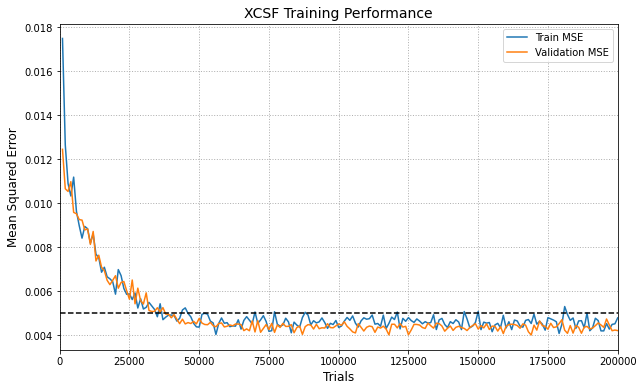

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(trials, train_mse, label="Train MSE")
plt.plot(trials, val_mse, label="Validation MSE")
plt.grid(linestyle="dotted", linewidth=1)
plt.axhline(y=xcs.E0, xmin=0, xmax=1, linestyle="dashed", color="k")
plt.title("XCSF Training Performance", fontsize=14)
plt.xlabel("Trials", fontsize=12)
plt.ylabel("Mean Squared Error", fontsize=12)
plt.xlim([0, N * xcs.MAX_TRIALS])
plt.legend()
plt.show()

### Compare with alternatives

In [6]:
# final XCSF test score
print(f"Restoring system from trial {val_trial:.0f} with val_mse={val_min:.5f}")
xcs.retrieve()
xcsf_pred = xcs.predict(X_test)
xcsf_mse = mean_squared_error(xcsf_pred, y_test)
print(f"XCSF Test MSE = {xcsf_mse:.4f}")

# compare with linear regression
lm = LinearRegression()
lm.fit(X_train, y_train)
lm_pred = lm.predict(X_test)
lm_mse = mean_squared_error(lm_pred, y_test)
print(f"Linear regression Test MSE = {lm_mse:.4f}")

# compare with MLP regressor
X_train = np.vstack((X_train, X_val))
y_train = np.vstack((y_train, y_val))
mlp = MLPRegressor(
    hidden_layer_sizes=(10,),
    activation="relu",
    solver="adam",
    learning_rate="adaptive",
    learning_rate_init=0.01,
    max_iter=1000,
    alpha=0.01,
    validation_fraction=0.1,
)
mlp.fit(X_train, y_train.ravel())
mlp_pred = mlp.predict(X_test)
mlp_mse = mean_squared_error(mlp_pred, y_test)
print(f"MLP Regressor Test MSE = {mlp_mse:.4f}")

Restoring system from trial 191000 with val_mse=0.00428
XCSF Test MSE = 0.0062
Linear regression Test MSE = 0.0239
MLP Regressor Test MSE = 0.0080


### Show some predictions vs. answers

In [7]:
pred = xcs.predict(X_test[:10])
print("*****************************")
print("first 10 predictions = ")
print(pred[:10])
print("*****************************")
print("first 10 answers = ")
print(y_test[:10])

*****************************
first 10 predictions = 
[[0.51109002]
 [0.63848591]
 [0.30761656]
 [0.57775982]
 [0.88727473]
 [0.57971158]
 [0.36386609]
 [0.39086393]
 [0.51336711]
 [0.42815228]]
*****************************
first 10 answers = 
[[0.46317407]
 [0.73366004]
 [0.1983963 ]
 [0.57780089]
 [0.94174278]
 [0.58153279]
 [0.27944002]
 [0.41401726]
 [0.53636454]
 [0.45255843]]
